# Kaggle Leaf Classification Challenge


In [ ]:
## Install pandas if you don't already have it (uncomment line below)

# ! pip install pandas

In [32]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
import random
#import data_utils // file copied at the end

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [3]:
!ls drive/'My Drive/DTU/Deep learning'

02456-deep-learning-with-PyTorch-master  sample_submission.csv	train.csv
images					 test.csv


Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [4]:
drive_path = 'drive/My Drive/DTU/Deep learning'
# local_path = ''  # if you're folder structure is as defined above and you want to run locally

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [5]:
image_paths = glob.glob(drive_path + "/images/*.jpg")
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv(drive_path + '/train.csv')
train_images = [drive_path + '/images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv(drive_path + '/test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [6]:
# Your code here:
print('Training samples: ' + str(len(train.species)))
print('Training info: ' + str(train.columns) + '\n')
print('Test samples: ' + str(len(test.id)))
print('Test info: ' + str(test.columns) + '\n')

n_species = len(train.species.unique())
species = train.species.unique()
all_species_tr = list(train.species)
print('Number of species :' + str(n_species))

print('Training samples for each species: ' + str({species[i]: all_species_tr.count(species[i]) for i in range(n_species)}))


Training samples: 990
Training info: Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

Test samples: 594
Test info: Index(['id', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6',
       'margin7', 'margin8', 'margin9',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=193)

Number of species :99
Training samples for each species: {'Acer_Opalus': 10, 'Pterocarya_Stenoptera': 10, 'Quercus_Hartwissiana': 10, 'Tilia_Tomentosa': 10, 'Quercus_Variabilis': 10, 'Magnolia_Salicifolia': 10, 'Quercus_Canariensis': 10, 'Quercus_Rubra': 10, 'Quercus_Brantii': 10, 'Salix_Fragilis': 10, 'Zelkova_S

 * **Answer:**
 For training we have 990 samples, while for testing we have 594. They have same information, except testing samlpes doesn't have species column. 
 There are 10 samples per each sepecies in training set

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

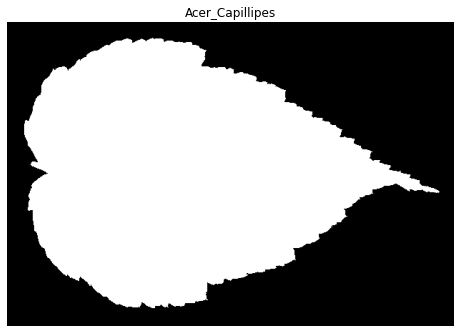

In [7]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index(drive_path + '/images/{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

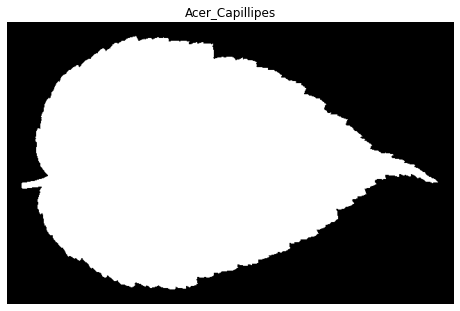

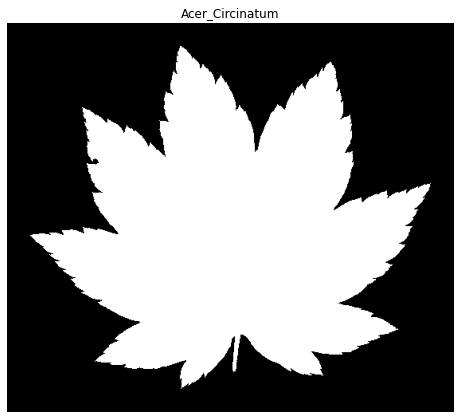

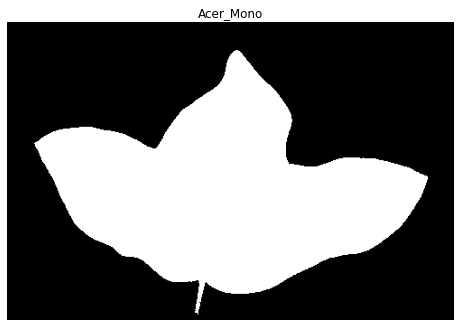

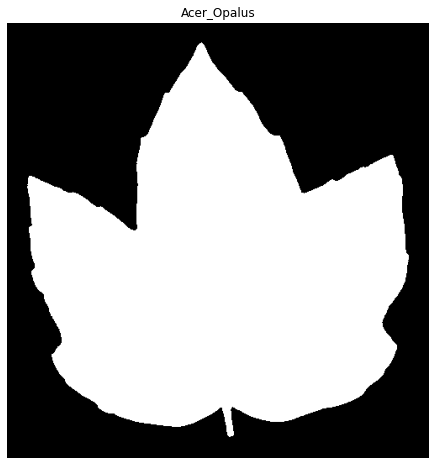

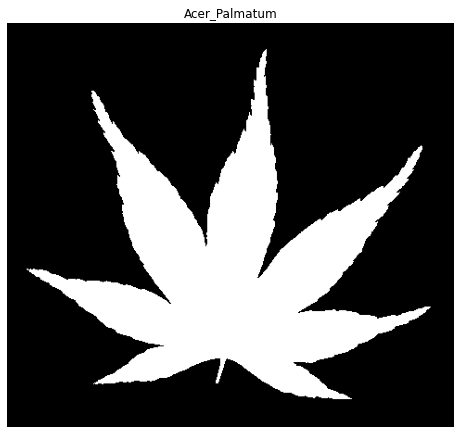

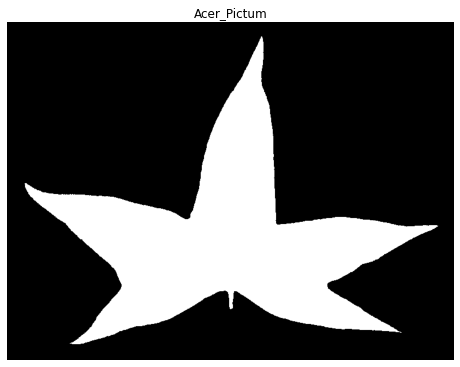

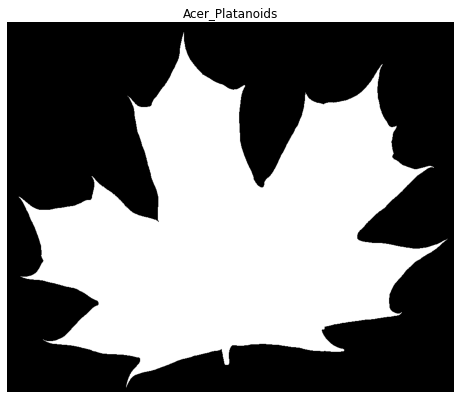

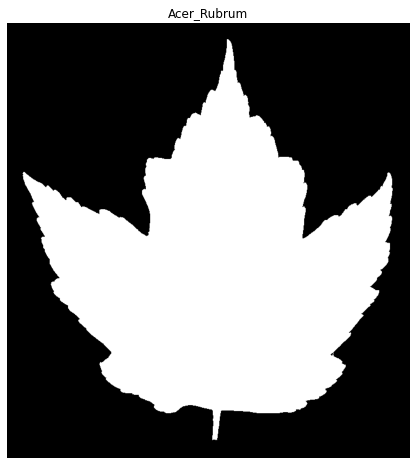

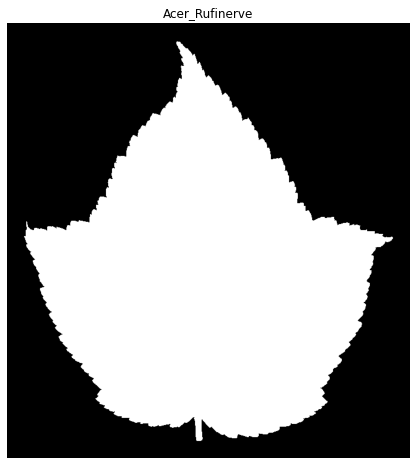

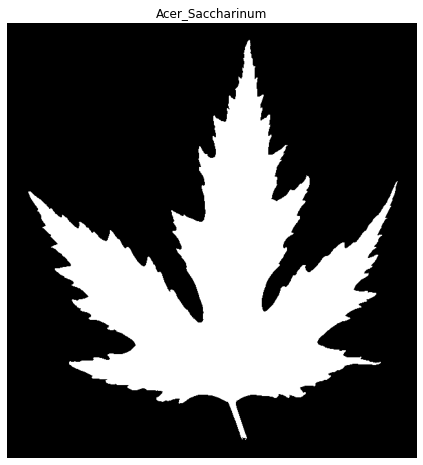

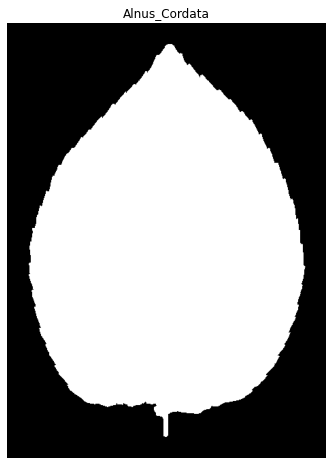

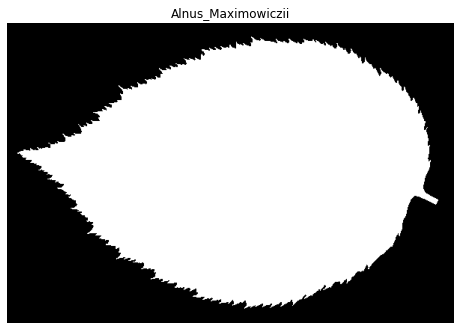

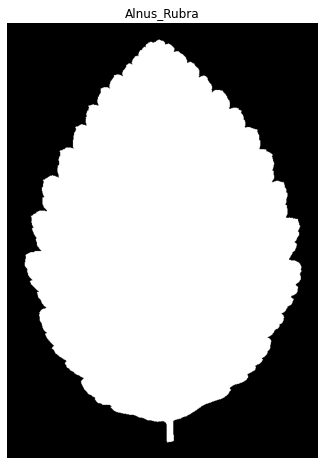

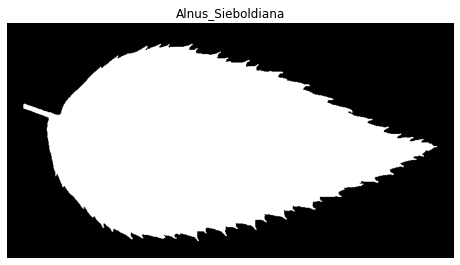

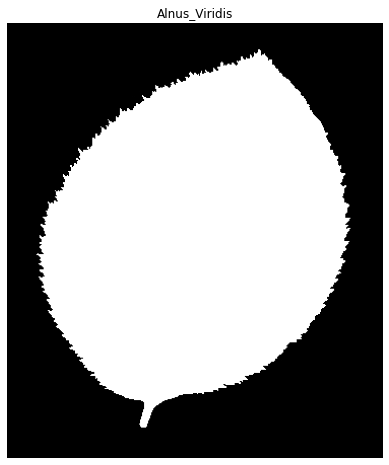

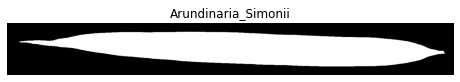

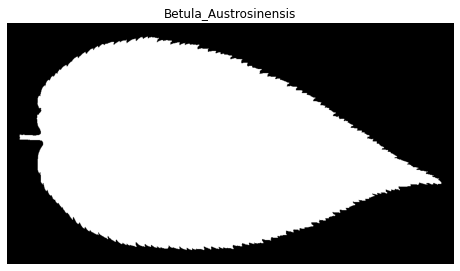

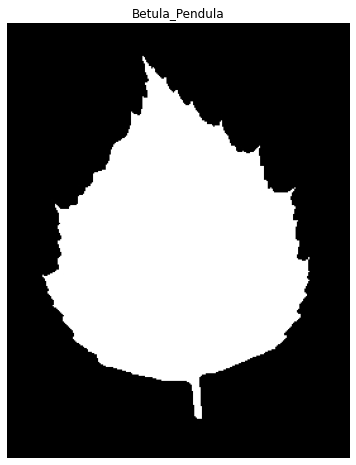

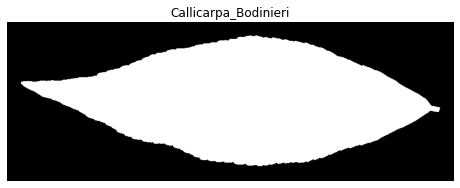

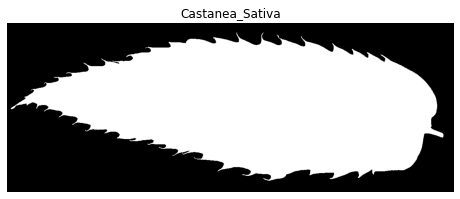

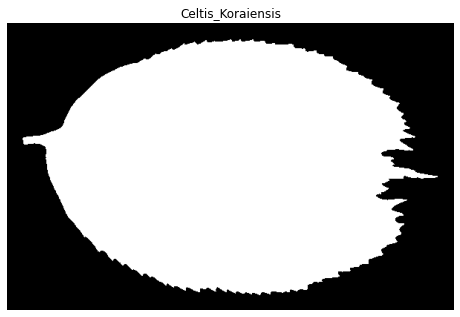

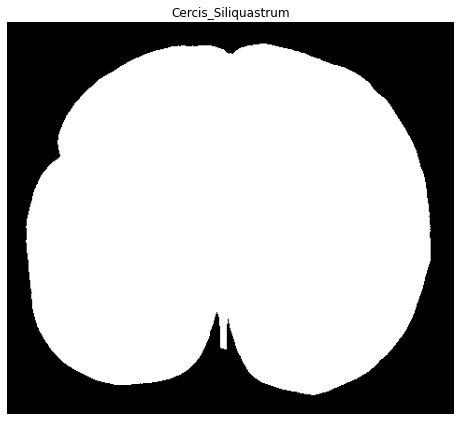

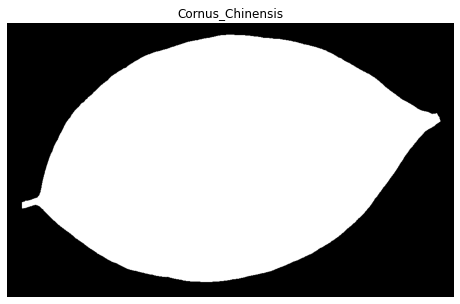

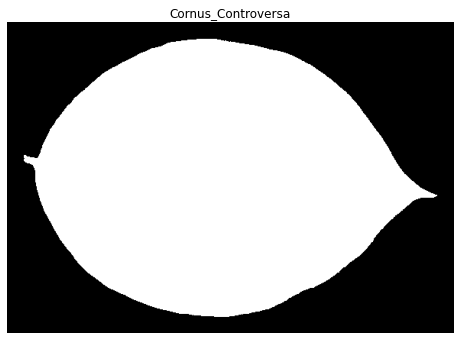

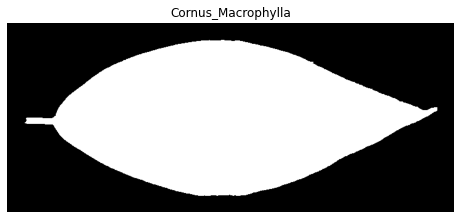

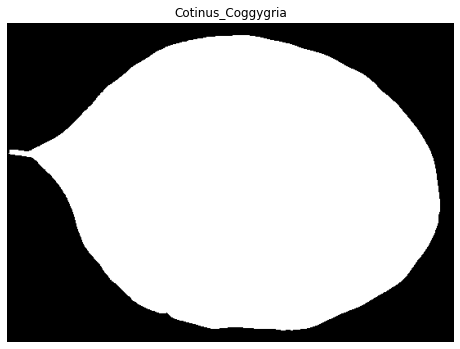

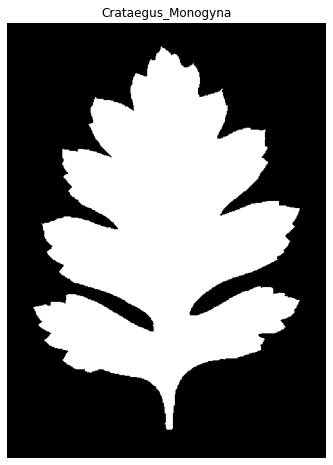

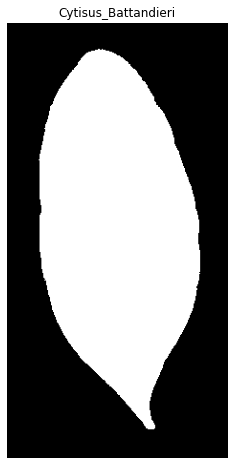

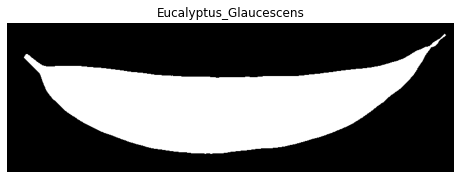

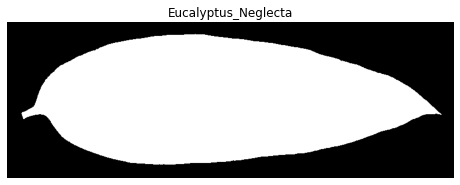

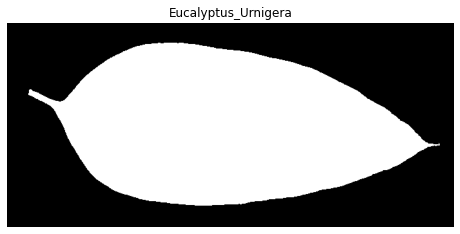

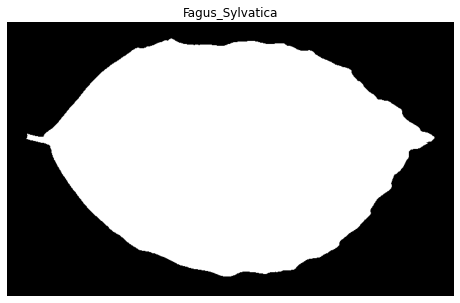

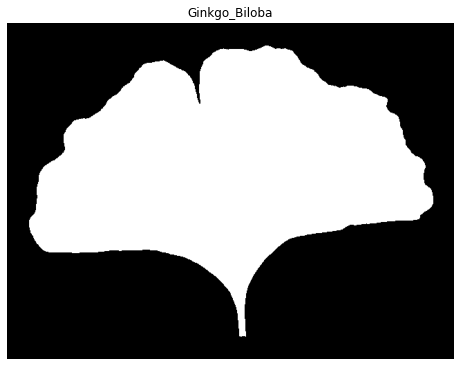

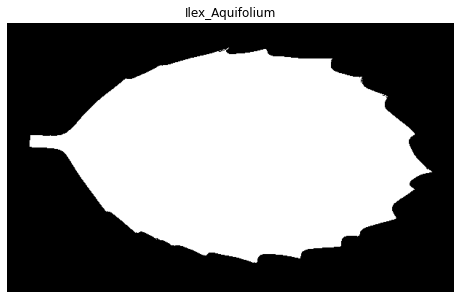

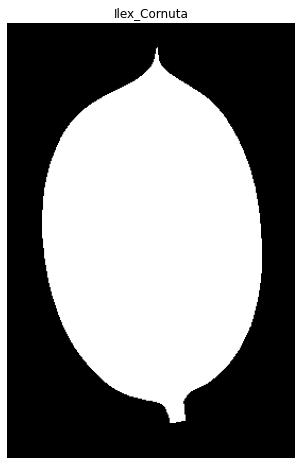

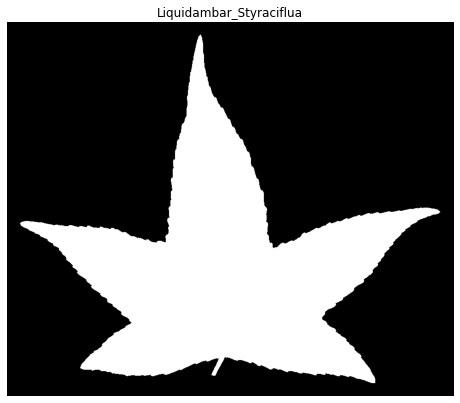

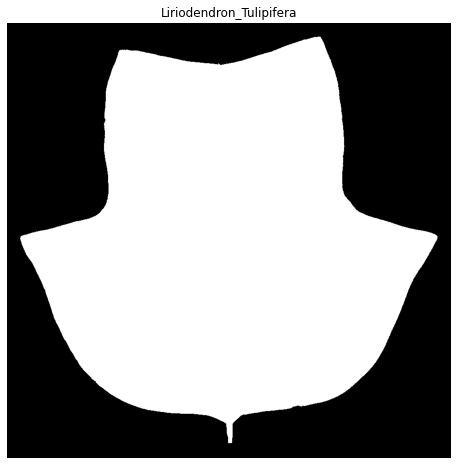

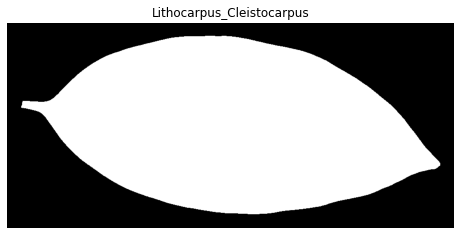

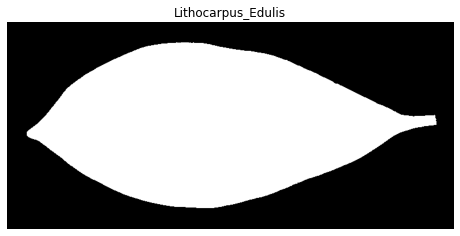

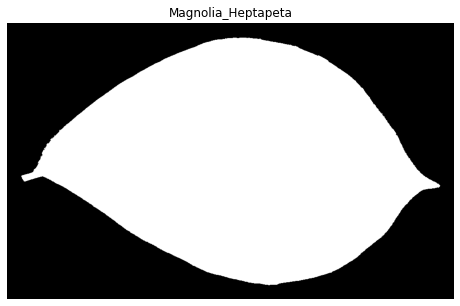

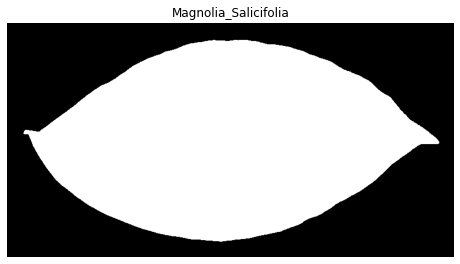

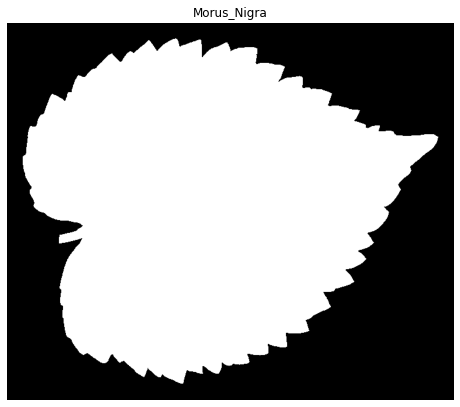

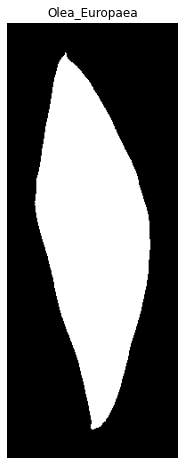

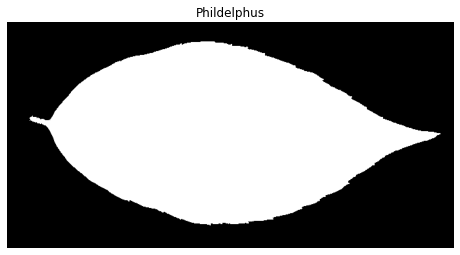

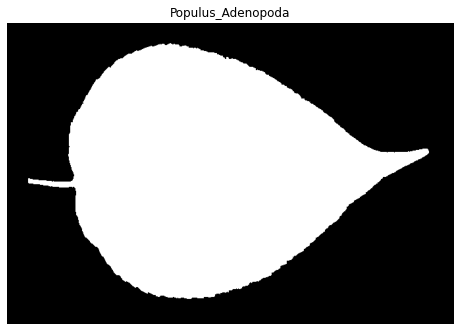

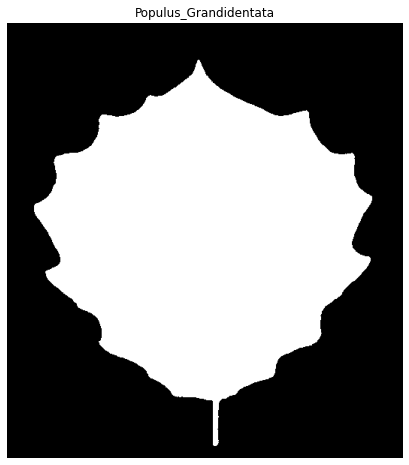

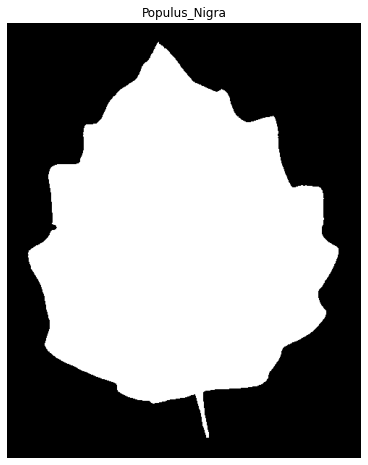

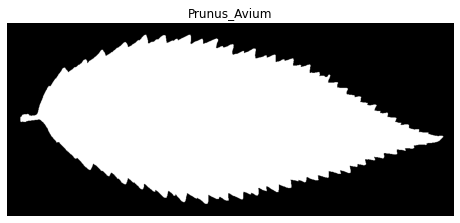

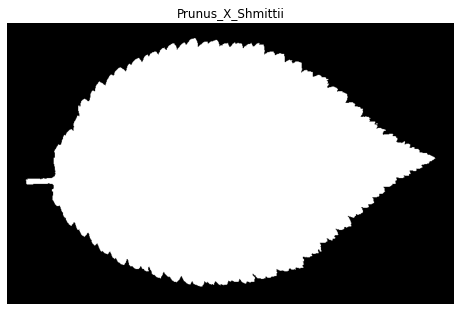

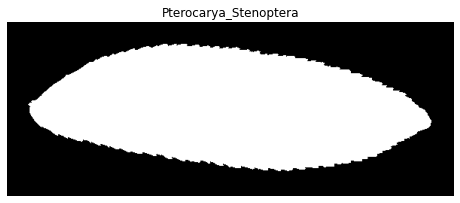

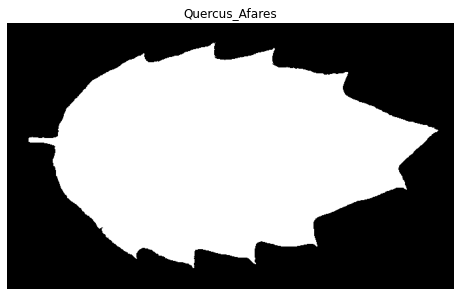

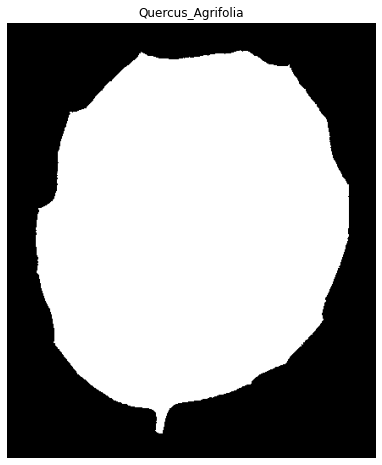

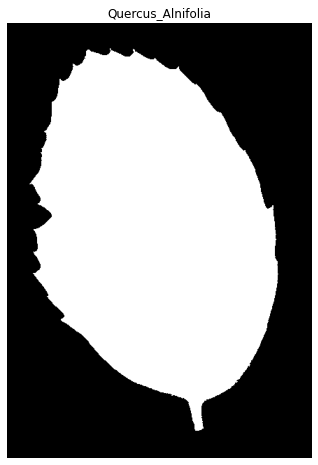

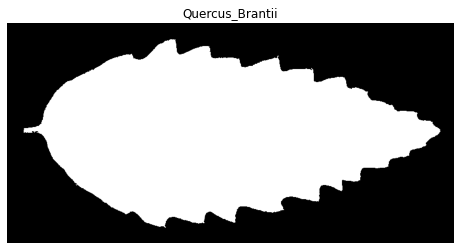

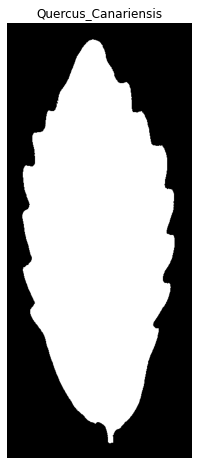

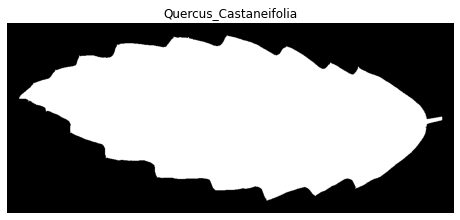

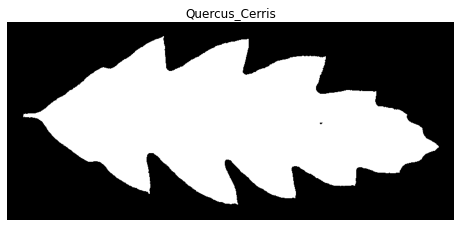

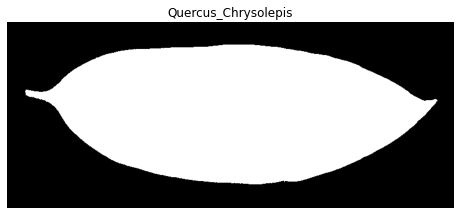

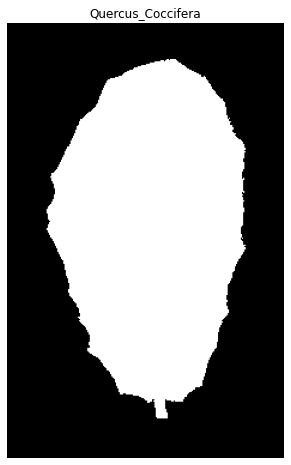

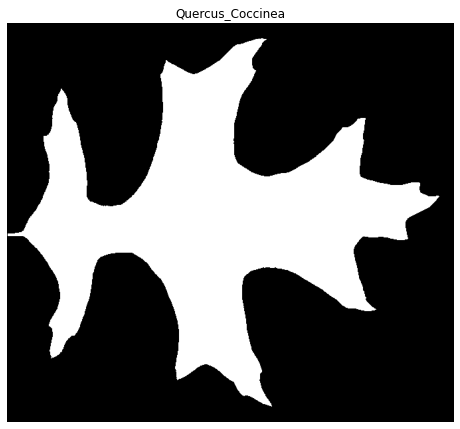

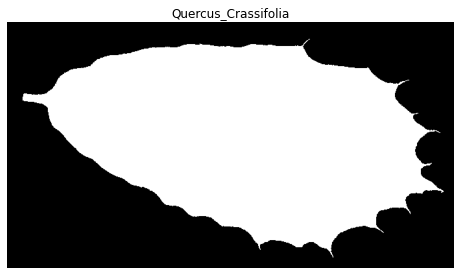

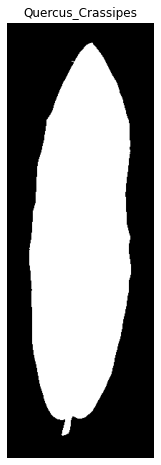

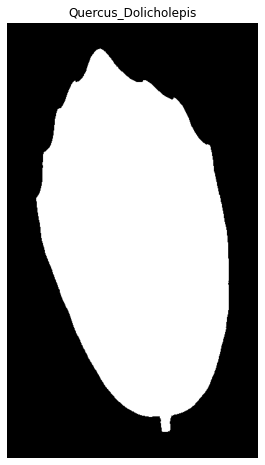

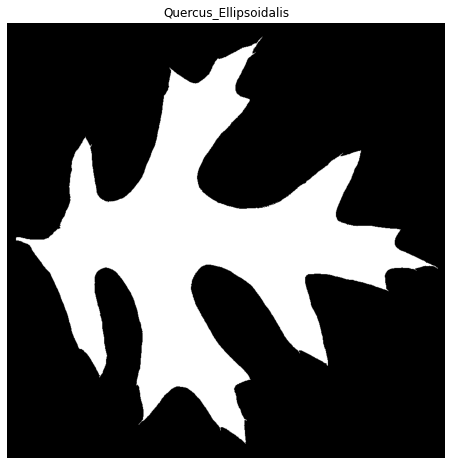

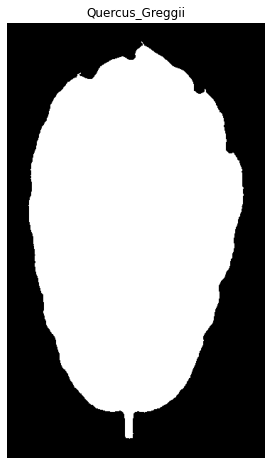

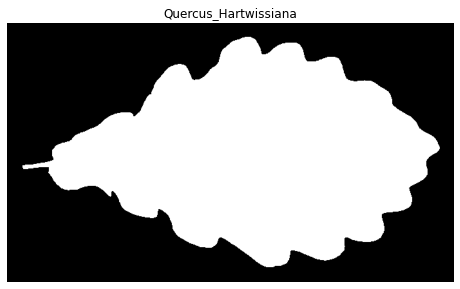

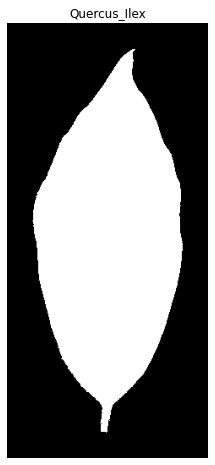

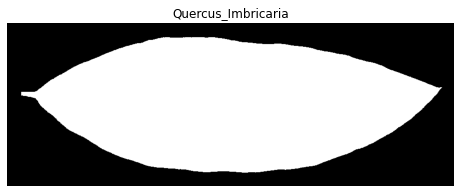

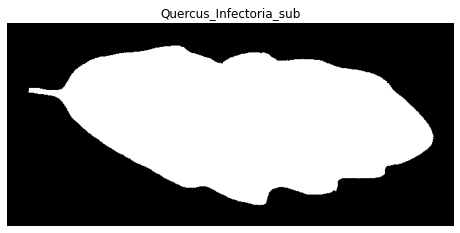

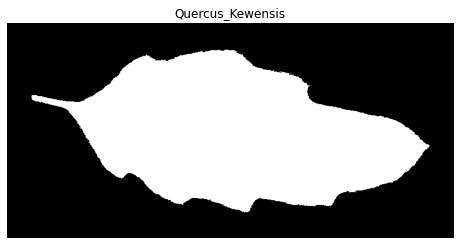

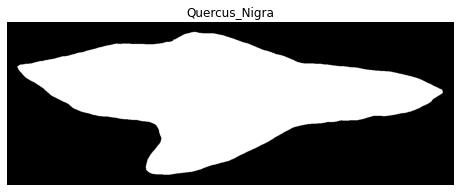

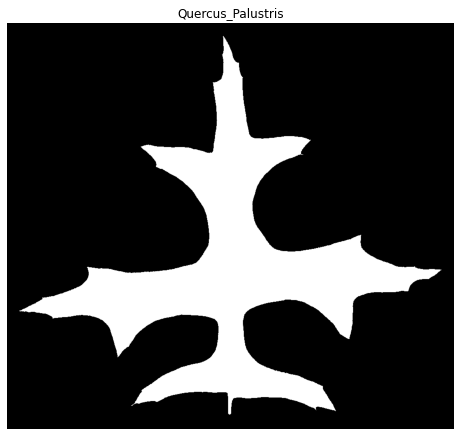

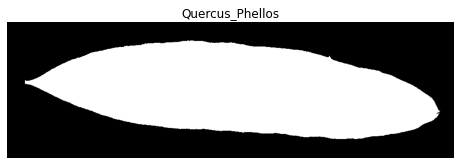

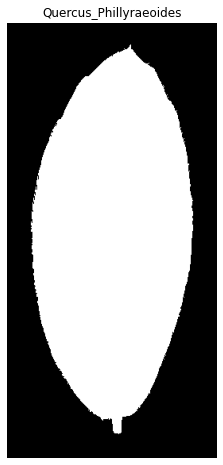

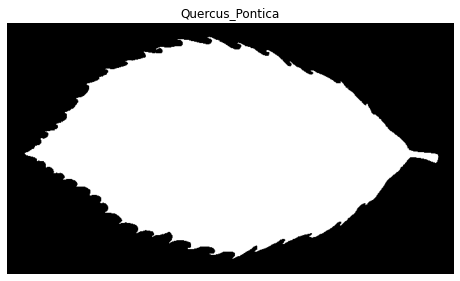

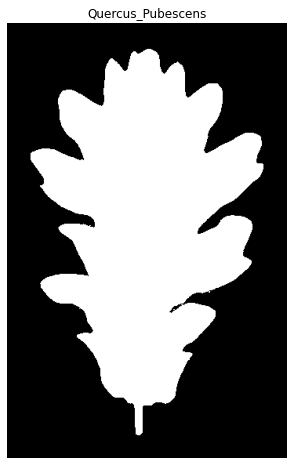

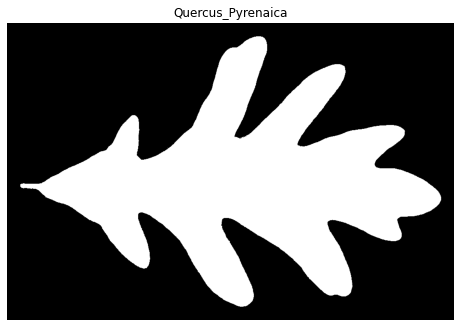

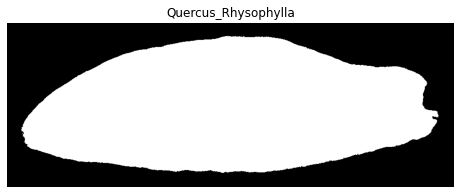

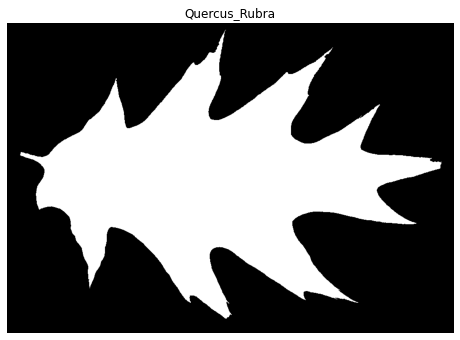

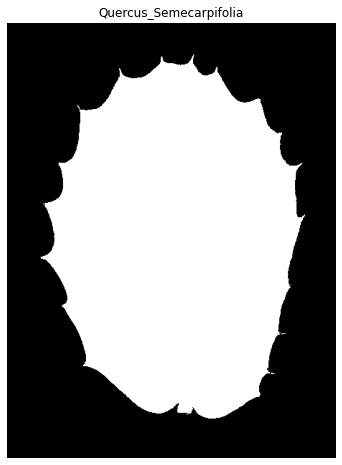

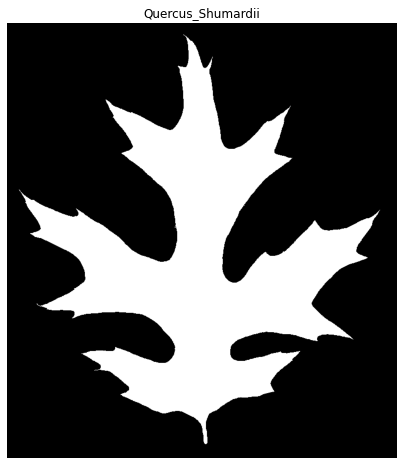

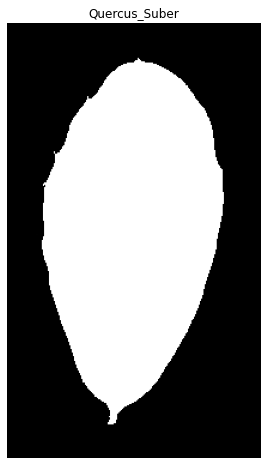

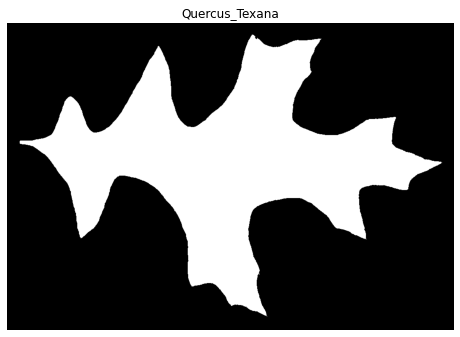

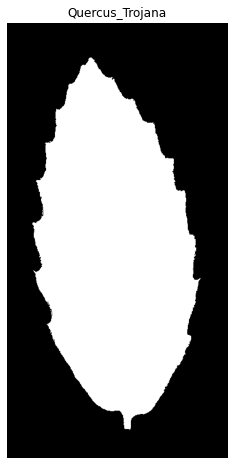

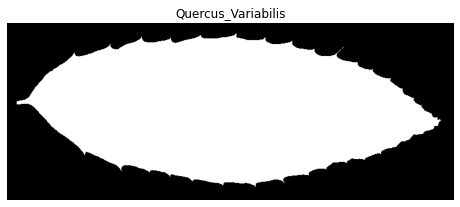

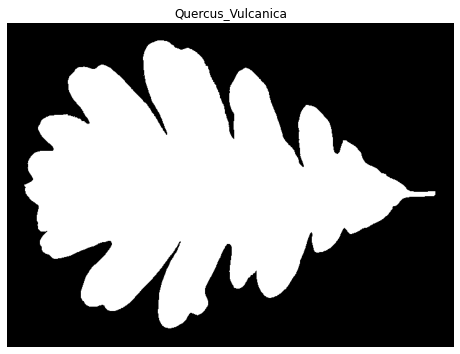

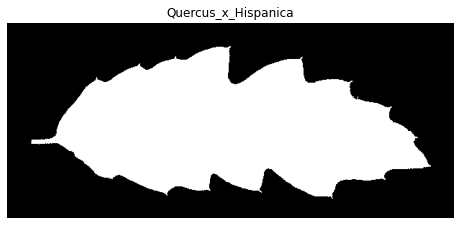

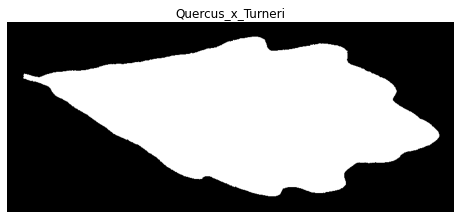

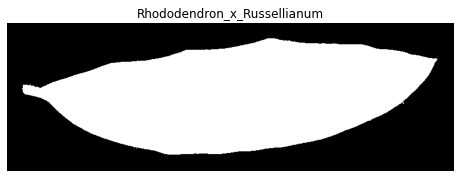

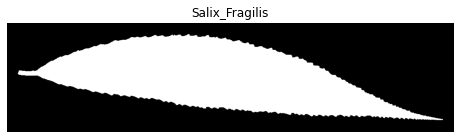

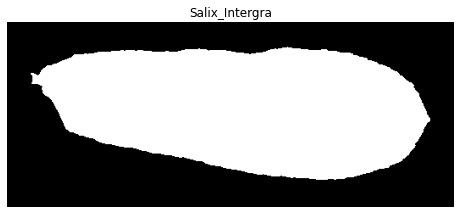

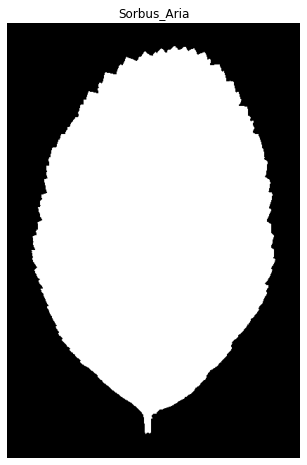

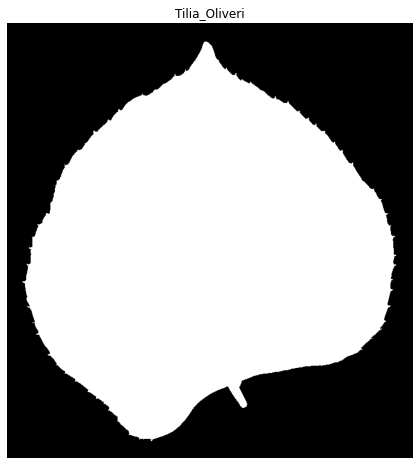

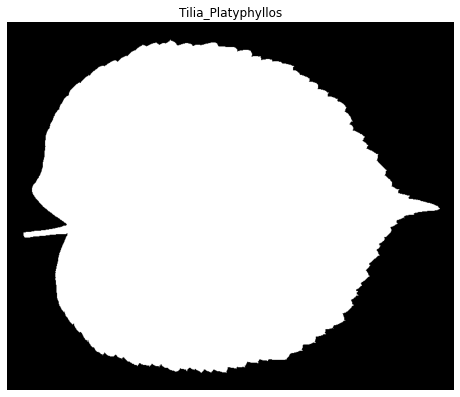

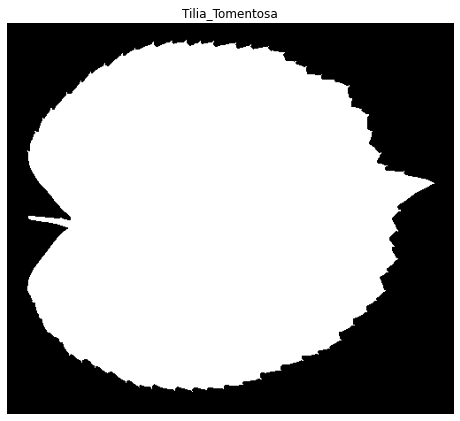

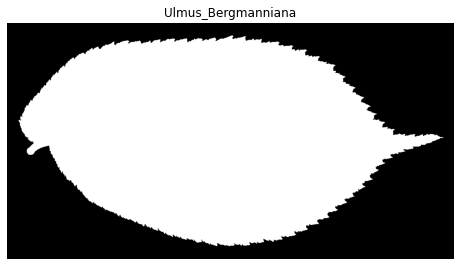

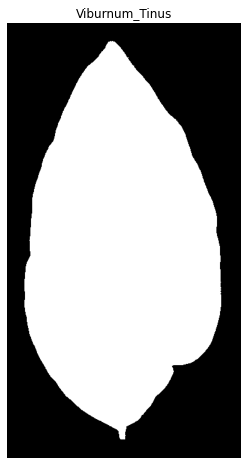

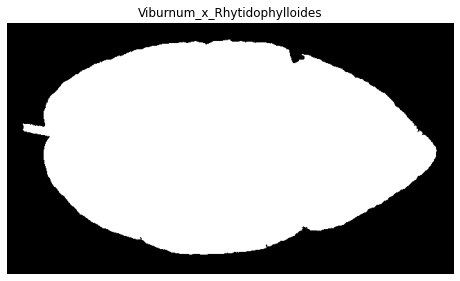

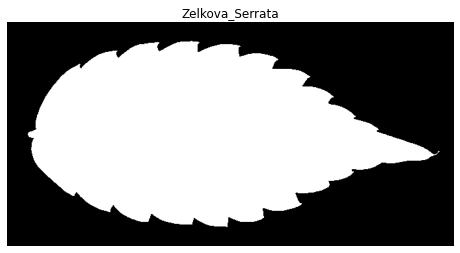

In [39]:
# Now plot 1 image from each category
for i in range(len(indexes)):
  plt.figure(figsize=(8,8))
  image = imread(image_paths[indexes[i]])
  plt.imshow(image, cmap='gray')
  plt.title(species[i])
  plt.axis('off')
  plt.show()

As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**


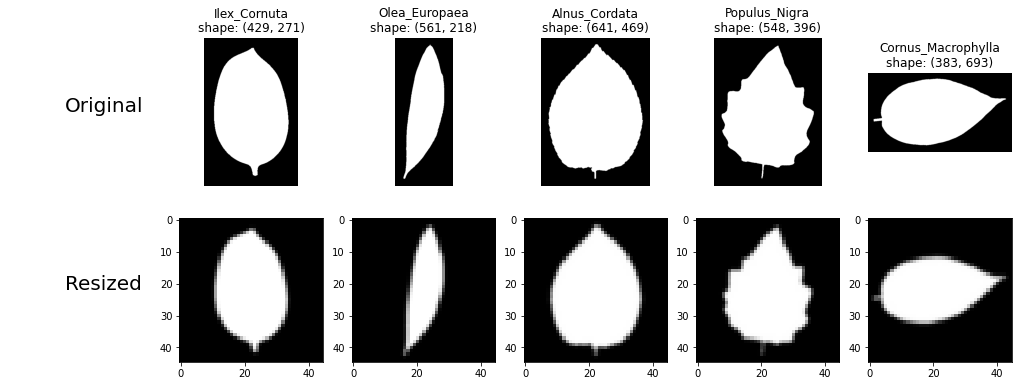

In [102]:
## Image pre-processing
h = w = 45
image_size = (h, w)  # <-- YOUR CODE HERE

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

In [79]:
print(image.shape)

(50, 50)


## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

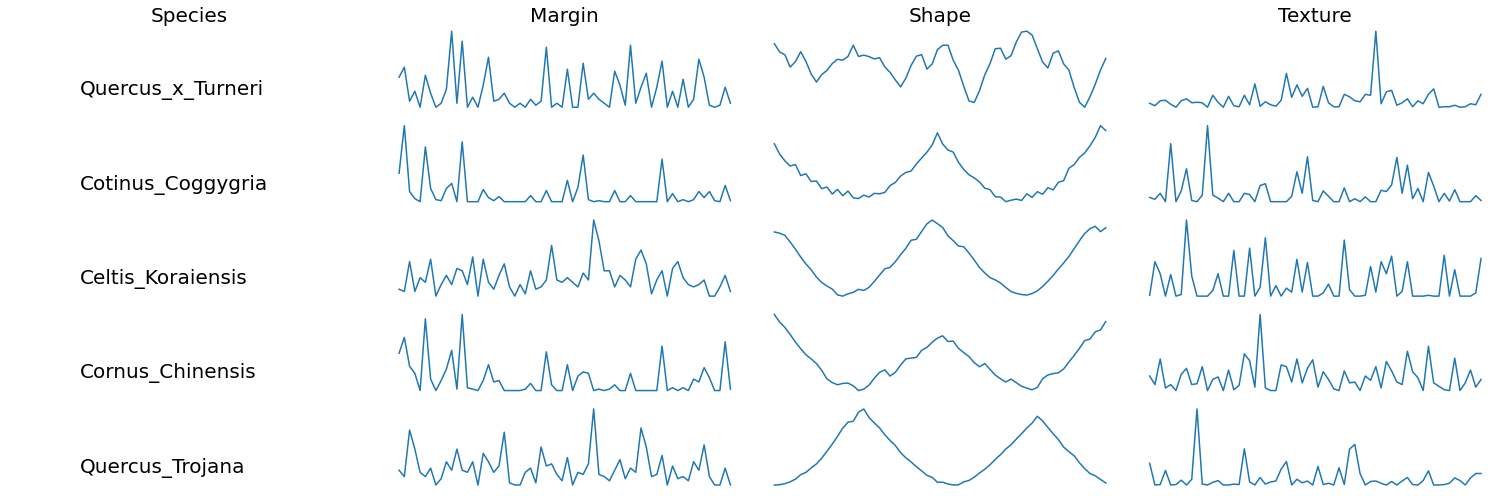

In [103]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 * **Answer:**
 
 For image processing we should use a CNN because it let us to know spatial information through the image. 
 For texture and Margin a FFNN is good because these features represents some patterns of the data.
 And for Shape feature, a RNN can be used. 

# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [104]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE =    (h, w, 1)# <-- Your answer here
NUM_CLASSES =    len(train.species.unique())# <-- Your answer here 
# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES =  64 # <-- Your answer here


In [105]:
# Paths to data
TRAIN_PATH = drive_path + "/train.csv" 
TEST_PATH = drive_path + "/test.csv" 
IMAGE_PATHS = glob.glob(drive_path + "/images/*.jpg")

# train holds both X (input) and t (target/truth)
data = load_data(train_path=TRAIN_PATH, 
                            test_path=TEST_PATH,
                            image_paths=IMAGE_PATHS,
                            image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

Loading training data
	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
Loading test data
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594

@@@Shape checking of data sets@@@
TRAIN
	images	(990, 45, 45, 1)0.280034
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 45, 45, 1)	0.280368
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [76]:
# import pickle

# # Dump the data into a pickle file
# with open(drive_path + '/data.pickle', 'wb') as f:
#     pickle.dump(data, f)

In [ ]:
# # Load the data from a pickle file
# with open(drive_path + '/data.pickle', 'rb') as f:
#     data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

 * **Answer:**
 Batch size is important because it let us to handle large quantities of data not having to store it all at one time which can cause memory problems. Larger batch sizes tend to not generalize very well the model causing overfitting, so it is preferable to choose a small size. 

In [83]:
print(train_batch)

{'margins': array([[0.011719, 0.009766, 0.005859, 0.009766, 0.009766, 0.046875,
        0.035156, 0.      , 0.007812, 0.025391, 0.015625, 0.009766,
        0.007812, 0.025391, 0.025391, 0.      , 0.050781, 0.      ,
        0.009766, 0.023438, 0.027344, 0.017578, 0.      , 0.035156,
        0.017578, 0.023438, 0.015625, 0.003906, 0.003906, 0.005859,
        0.007812, 0.011719, 0.021484, 0.      , 0.021484, 0.029297,
        0.      , 0.009766, 0.013672, 0.007812, 0.      , 0.025391,
        0.03125 , 0.007812, 0.023438, 0.013672, 0.019531, 0.039062,
        0.001953, 0.029297, 0.025391, 0.025391, 0.052734, 0.001953,
        0.023438, 0.009766, 0.009766, 0.015625, 0.001953, 0.001953,
        0.      , 0.025391, 0.003906, 0.007812],
       [0.      , 0.      , 0.005859, 0.027344, 0.052734, 0.      ,
        0.001953, 0.      , 0.005859, 0.      , 0.      , 0.023438,
        0.      , 0.003906, 0.033203, 0.      , 0.009766, 0.001953,
        0.011719, 0.003906, 0.003906, 0.017578, 0.     

In [190]:
batch_size = 32
dummy_batch_gen = batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (32, 45, 45, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ts, (32, 99)

VALID
	images, (32, 45, 45, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ts, (32, 99)

TEST
	images, (32, 45, 45, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ids, 32


# Build the model

In [191]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [192]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [247]:
from pandas.core.indexes.interval import find_common_type
height, width, channels = IMAGE_SHAPE
print(channels)
print(height)

conv_out_channels = 64 # <-- Filters in your convolutional layer
kernel_size =       3  # <-- Kernel size
conv_stride =       1  # <-- Stride
conv_pad    =       0  # <-- Padding
 
# Keep track of features to output layer
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #L1 Img In (?, 50, 50, 1) -> Conv_1 : (?, 24, 24, 32) -> MaxPool: (20, 12, 12, 32)
        self.conv_layer_1 = nn.Sequential(
            Conv2d(in_channels=channels, out_channels=conv_out_channels,
            kernel_size=kernel_size, stride=conv_stride, padding=conv_pad),
            MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()
            )
        
        self.conv_layer_2 = nn.Sequential(
            Conv2d(in_channels=conv_out_channels, out_channels=128,
            kernel_size=kernel_size, stride=conv_stride, padding=conv_pad),
            MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()
            )
        
        self.conv_layer_3 = nn.Sequential(
            Conv2d(in_channels=128, out_channels=128,
            kernel_size=2, stride=conv_stride, padding=conv_pad),
            MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()
            )
        
        
        # Exercise: Add a recurrent unit like and RNN or GRU
        # >> YOUR CODE HERE <<
        
        self.rnn = nn.RNN(input_size=NUM_FEATURES, hidden_size=64, num_layers=1, batch_first=True)

        self.fc_1 = nn.Sequential(
            Linear(2240, 1000),
            Dropout(0.3),
            nn.ReLU(),
            BatchNorm1d(1000)
        )
        
        self.fc_2 = nn.Sequential(
            Linear(1000, 100),
            Dropout(0.3),
            nn.ReLU(),
            BatchNorm1d(100)
        )

        self.l_out = Linear(in_features=100,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        x_img = x_img.permute(0,3,1,2)
        out_conv = self.conv_layer_1(x_img)
        out_conv = self.conv_layer_2(out_conv)
        out_conv = self.conv_layer_3(out_conv)

        features_img = out_conv.reshape(out_conv.size(0),-1)
        
        # Append features to the list "features"
        features.append(features_img)
        
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # if you want to use features as feature vectors
        features_vector = x
        features.append(features_vector)
        
        
        ## Use concatenated leaf features for RNN ##
        # - Chage dimensions to fit GRU
        # - Apply GRU
        # - Change dimensions s.t. the features can be used in the final FFNN output layer

        # >> YOUR CODE HERE <<
        out_rnn, nada = self.rnn(x_shape)
        features_rnn = out_rnn.reshape(out_rnn.size(0), -1)
        # Append features to the list "features"
        features.append(features_rnn)
        
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)

        out_fc = self.fc_1(features_final)
        out_fc = self.fc_2(out_fc)
        
        out['out'] = self.l_out(out_fc) 
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

1
45
Net(
  (conv_layer_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (rnn): RNN(64, 64, batch_first=True)
  (fc_1): Sequential(
    (0): Linear(in_features=2240, out_features=1000, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_2): Sequential(
    (0): Linear(in_features=1000, out_features=100, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): R

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [248]:
LEARNING_RATE = 0.0005
criterion = nn.CrossEntropyLoss()          # <-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [249]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

print(_x_image.shape)
# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

torch.Size([32, 45, 45, 1])


tensor([[ 0.1872, -0.1354, -0.0132,  ..., -0.4364, -0.7307, -0.1013],
        [-0.0923,  0.3898, -0.0844,  ...,  0.8954,  1.3361,  0.3640],
        [-0.9769, -0.9164,  0.2049,  ..., -0.5298, -0.4845,  0.0369],
        ...,
        [ 1.0633,  0.5577, -0.2587,  ...,  0.0513, -0.1771,  0.1837],
        [ 0.1438, -0.1442,  0.1747,  ...,  0.0330, -0.4364,  0.3834],
        [ 0.8393,  0.8679, -0.6596,  ...,  0.9596,  1.0247, -0.1377]],
       grad_fn=<MmBackward0>)

# Train

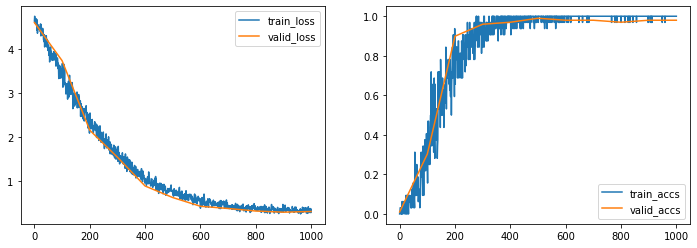

In [250]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 1000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = batch_generator(data,
                            batch_size=batch_size,
                            num_classes=NUM_CLASSES,
                            num_iterations=max_iter,
                            seed=42,
                            val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
        
    if max_iter < i:
        break

In [254]:
print('Max Valid accuracy: ' + str(max(valid_accs)))

Max Valid accuracy: 0.989899


## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture: 
3 convolutional layers has been used for images. 
1 RNN has been used for Shape feature. 
Finally, concatenating convolutional output, RNN output, margin ,and texture 2 fully connected layers with dropout before activation functions and batch norm after it has been used. 
At the end, a linear layer output the results. 

* Description of the training parameters
Learning rate has been decreased due to oscillations of the loss during training. 

* Description of the final results (Kaggle and validation)

**Answer:**


# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [121]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

## Make submission file

In [122]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(drive_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,-13.441570,-11.333570,-17.449747,-8.575026,-11.941041,-15.920218,-18.816328,-10.608634,-7.852924,...,-17.199312,-21.297209,-7.813333,-13.476546,-14.556229,-13.188996,-13.681744,-9.614424,-21.085125,-15.946228
1,7,-13.574501,-15.051118,-12.144441,-14.276847,-15.613474,-13.722347,-14.167623,-14.438319,-14.797091,...,-20.856546,-11.114155,-16.750307,-14.898769,-13.053811,-15.520444,-10.660980,-15.468834,-16.472073,-8.665048
2,9,-17.856138,-10.770792,-22.700884,-13.631531,-13.715808,-18.298168,-12.813112,-14.645769,-16.223154,...,-22.398933,-20.555117,-17.547050,-15.608269,-21.175020,-12.324193,-21.007427,-19.882555,-22.601965,-23.268112
3,12,-14.378154,-14.130816,-12.572511,-13.023125,-14.306496,-13.399879,-13.056138,-13.772509,-13.092676,...,-19.105019,-7.739276,-15.768475,-14.564612,-14.594137,-14.370571,-13.525338,-14.528316,-14.646812,-16.058752
4,13,-17.581444,-10.247096,-22.126709,-11.639055,-13.349142,-16.744877,-15.552368,-17.598534,-15.600828,...,-21.204683,-23.503357,-5.367944,-11.878243,-8.239860,-10.428881,-15.954443,-16.139463,-24.990984,-24.182043


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 

In [9]:
## Data_utils.py

import numpy as np
import pandas as pd
import os

from PIL import Image, ImageOps
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    #from sklearn.cross_validation import StratifiedShuffleSplit
    # cross_validation -> now called: model_selection
    # https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation
    from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold


def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[int(row), int(col)] = 1
    return out


def pad2square(img):
    img_shape = img.shape
    r = img_shape[0]
    c = img_shape[1]
    new_side = np.max([r,c])
    padding = ((new_side - c)//2, (new_side - r)//2, int(np.ceil((new_side - c)/2)), int(np.ceil((new_side - r)/2)))
    img_as_img = Image.fromarray(img)
    new_img = ImageOps.expand(img_as_img, padding)
    return np.array(new_img)


class load_data():
    # data_train, data_test and le are public
    def __init__(self, train_path, test_path, image_paths, image_shape=(128, 128)):
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        image_paths = image_paths
        image_shape = image_shape
        self._load(train_df, test_df, image_paths, image_shape)
        
    def _load(self, train_df, test_df, image_paths, image_shape):
        # load train.csv
        path_dict = self._path_to_dict(image_paths) # numerate image paths and make it a dict
        # merge image paths with data frame
        train_image_df = self._merge_image_df(train_df, path_dict)
        test_image_df = self._merge_image_df(test_df, path_dict)
        # label encoder-decoder (self. because we need it later)
        self.le = LabelEncoder().fit(train_image_df['species'])
        # labels for train
        t_train = self.le.transform(train_image_df['species'])
        # getting data
        print("Loading training data")
        train_data = self._make_dataset(train_image_df, image_shape, t_train)
        print("Loading test data")
        test_data = self._make_dataset(test_image_df, image_shape)        
        # need to reformat the train for validation split reasons in the batch_generator
        self.train = self._format_dataset(train_data, for_train=True)
        self.test = self._format_dataset(test_data, for_train=False)
        

    def _path_to_dict(self, image_paths):
        path_dict = dict()
        for image_path in image_paths:
            num_path = int(os.path.basename(image_path[:-4]))
            path_dict[num_path] = image_path
        return path_dict

    def _merge_image_df(self, df, path_dict):
        split_path_dict = dict()
        for index, row in df.iterrows():
            split_path_dict[row['id']] = path_dict[row['id']]
        image_frame = pd.DataFrame(list(split_path_dict.values()), columns=['image'])
        df_image =  pd.concat([image_frame, df], axis=1)
        return df_image
        
    def _make_dataset(self, df, image_shape, t_train=None):
        # make dataset
        data = dict()
        # merge image with 3x64 features
        for i, dat in enumerate(df.iterrows()):
            index, row = dat
            sample = dict()
            if t_train is not None:
                features = row.drop(['id', 'species', 'image'], axis=0).values
            else:
                features = row.drop(['id', 'image'], axis=0).values
            sample['margin'] = features[:64]
            sample['shape'] = features[64:128]
            sample['texture'] = features[128:]
            if t_train is not None:
                sample['t'] = np.asarray(t_train[i], dtype='int32')
            image = imread(row['image'], as_gray=True)
            image = pad2square(image)
            image = resize(image, output_shape=image_shape, mode='reflect', anti_aliasing=True)
            image = np.expand_dims(image, axis=2)
            sample['image'] = image   
            data[row['id']] = sample
            if i % 100 == 0:
                print("\t%d of %d" % (i, len(df)))
        return data

    def _format_dataset(self, df, for_train):
        # making arrays with all data in, is nessesary when doing validation split
        data = dict()
        value = list(df.values())[0]
        img_tot_shp = tuple([len(df)] + list(value['image'].shape))
        data['images'] = np.zeros(img_tot_shp, dtype='float32')
        feature_tot_shp = (len(df), 64)
        data['margins'] = np.zeros(feature_tot_shp, dtype='float32')
        data['shapes'] = np.zeros(feature_tot_shp, dtype='float32')
        data['textures'] = np.zeros(feature_tot_shp, dtype='float32')
        if for_train:
            data['ts'] = np.zeros((len(df),), dtype='int32')
        else:
            data['ids'] = np.zeros((len(df),), dtype='int32')
        for i, pair in enumerate(df.items()):
            key, value = pair
            data['images'][i] = value['image']
            data['margins'][i] = value['margin']
            data['shapes'][i] = value['shape']
            data['textures'][i] = value['texture']
            if for_train:
                data['ts'][i] = value['t']
            else:
                data['ids'][i] = key
        return data

    
class batch_generator():
    def __init__(self, data, batch_size=64, num_classes=99,
                 num_iterations=5e3, num_features=64, seed=42, val_size=0.1):
        self._train = data.train
        self._test = data.test
        # get image size
        value = self._train['images'][0]
        self._image_shape = list(value.shape)
        self._batch_size = batch_size
        self._num_classes = num_classes
        self._num_iterations = num_iterations
        self._num_features = num_features
        self._seed = seed
        self._val_size = val_size
        self._valid_split()

    def _valid_split(self):
        #from sklearn.cross_validation import StratifiedShuffleSplit
        # cross_validation -> now called: model_selection
        # https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation
    
        #self._idcs_train, self._idcs_valid =next(iter(
        #    StratifiedShuffleSplit(#self._train['ts'],
        #                           n_iter=1, # Changed to n_splits in model_selection
        #                           #n_splits=1,
        #                           test_size=self._val_size,
        #                           random_state=self._seed)))
        
        # Updated to use: model_selection
        sss = StratifiedShuffleSplit(
            n_splits=1,
            test_size=self._val_size,
            random_state=self._seed
        ).split(
            np.zeros(self._train['ts'].shape),  # Needed in StratifiedShuffleSplit for nothing...
            self._train['ts']
        )
        self._idcs_train, self._idcs_valid = next(iter(sss))
        
    def _shuffle_train(self):
        np.random.shuffle(self._idcs_train)

    def _batch_init(self, purpose):
        assert purpose in ['train', 'valid', 'test']
        batch_holder = dict()
        batch_holder['margins'] = np.zeros((self._batch_size, self._num_features), dtype='float32')
        batch_holder['shapes'] = np.zeros((self._batch_size, self._num_features), dtype='float32')
        batch_holder['textures'] = np.zeros((self._batch_size, self._num_features), dtype='float32')
        batch_holder['images'] = np.zeros(tuple([self._batch_size] + self._image_shape), dtype='float32')
        if (purpose == "train") or (purpose == "valid"):
            batch_holder['ts'] = np.zeros((self._batch_size, self._num_classes), dtype='float32')          
        else:
            batch_holder['ids'] = []
        return batch_holder

    def gen_valid(self):
        batch = self._batch_init(purpose='valid')
        i = 0
        for idx in self._idcs_valid:
            batch['margins'][i] = self._train['margins'][idx]
            batch['shapes'][i] = self._train['shapes'][idx]
            batch['textures'][i] = self._train['textures'][idx]
            batch['images'][i] = self._train['images'][idx]
            batch['ts'][i] = onehot(np.asarray([self._train['ts'][idx]], dtype='float32'), self._num_classes)
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='valid')
                i = 0
        if i != 0:
            batch['ts'] = batch['ts'][:i]
            batch['margins'] = batch['margins'][:i]
            batch['shapes'] = batch['shapes'][:i]
            batch['textures'] = batch['textures'][:i]
            batch['images'] = batch['images'][:i]
            yield batch, i

    def gen_test(self):
        batch = self._batch_init(purpose='test')
        i = 0
        for idx in range(len(self._test['ids'])):
            batch['margins'][i] = self._test['margins'][idx]
            batch['shapes'][i] = self._test['shapes'][idx]
            batch['textures'][i] = self._test['textures'][idx]
            batch['images'][i] = self._test['images'][idx]
            batch['ids'].append(self._test['ids'][idx])
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='test')
                i = 0
        if i != 0:
            yield batch, i       

    def gen_train(self):
        batch = self._batch_init(purpose='train')
        iteration = 0
        i = 0
        while True:
            # shuffling all batches
            self._shuffle_train()
            for idx in self._idcs_train:
                # extract data from dict
                batch['margins'][i] = self._train['margins'][idx]
                batch['shapes'][i] = self._train['shapes'][idx]
                batch['textures'][i] = self._train['textures'][idx]
                batch['images'][i] = self._train['images'][idx]
                batch['ts'][i] = onehot(np.asarray([self._train['ts'][idx]], dtype='float32'), self._num_classes)
                i += 1
                if i >= self._batch_size:
                    yield batch
                    batch = self._batch_init(purpose='train')
                    i = 0
                    iteration += 1
                    if iteration >= self._num_iterations:
                        break